Assignnement 2: Prediction and Classification

Due: Thursday, April 30, 2015 11:59 PM


# Introduction
Problem 3 is optional - for extra credit!
Problems 1 and 2 will be graded for the Lab 2.  


In this assignment you will be using regression and classification to explore different data sets.  

**First**: You will use data from before 2002 in the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics) to create a metric for picking baseball players using linear regression.  This database contains the "complete batting and pitching statistics from 1871 to 2013, plus fielding statistics, standings, team stats, managerial records, post-season data, and more". [Documentation provided here](http://seanlahman.com/files/database/readme2012.txt).

!["Sabermetrics Science"](http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg)
http://saberseminar.com/wp-content/uploads/2012/01/saber-web.jpg

**Second**: You will use the famous [iris](http://en.wikipedia.org/wiki/Iris_flower_data_set) data set to perform a $k$-neareast neighbor classification using cross validation.  While it was introduced in 1936, it is still [one of the most popular](http://archive.ics.uci.edu/ml/) example data sets in the machine learning community. Wikipedia describes the data set as follows: "The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres." Here is an illustration what the four features measure:

!["iris data features"](http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png)
http://sebastianraschka.com/Images/2014_python_lda/iris_petal_sepal.png

**Third**: You will investigate the influence of higher dimensional spaces on the classification using another standard data set in machine learning called the The [cars data set](https://archive.ics.uci.edu/ml/datasets/Automobile).  


## Load Python modules

In [2]:
# prepare the notebook for matplotlib
%matplotlib inline 

import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn
import sklearn.datasets
import sklearn.cross_validation
import sklearn.decomposition
import sklearn.grid_search
import sklearn.neighbors
import sklearn.metrics

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Sabermetrics

Using data preceding the 2002 season pick 10 offensive players keeping the payroll under $20 million (assign each player the median salary). Predict how many games this team would win in a 162 game season.  

In this problem we will be returning to the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics).  From this database, we will be extract five data sets containing information such as yearly stats and standing, batting statistics, fielding statistics, player names, player salaries and biographical information. You will explore the data in this database from before 2002 and create a metric for picking players. 

#### Problem 1(a) 

Load in [these CSV files](http://seanlahman.com/files/database/lahman-csv_2014-02-14.zip) from the [Sean Lahman's Baseball Database](http://seanlahman.com/baseball-archive/statistics). For this assignment, we will use the 'Teams.csv', 'Batting.csv', 'Salaries.csv', 'Fielding.csv', 'Master.csv' tables. Read these tables into separate pandas DataFrames with the following names. 

CSV file name | Name of pandas DataFrame
:---: | :---: 
Teams.csv | teams
Batting.csv | players
Salaries.csv | salaries
Fielding.csv | fielding
Master.csv | master

In [80]:
teams = pd.read_csv("data/Teams.csv")
players = pd.read_csv("data/Batting.csv")
salaries = pd.read_csv("data/Salaries.csv")
fielding = pd.read_csv("data/Fielding.csv")
master = pd.read_csv("data/Master.csv")

#### Problem 1(b)

Calculate the median salary for each player and create a pandas DataFrame called `medianSalaries` with four columns: (1) the player ID, (2) the first name of the player, (3) the last name of the player and (4) the median salary of the player. Show the head of the `medianSalaries` DataFrame.   

In [81]:
medians = salaries.groupby(["playerID"]).median()
merged = pd.merge(medians, master, left_index=True, right_on="playerID")
medianSalaries=merged[["nameFirst", "nameLast", "salary"]]
medianSalaries.reset_index(inplace=True, drop=True)
medianSalaries.head()

,nameFirst,nameLast,salary
0,David,Aardsma,419000
1,Don,Aase,612500
2,Andy,Abad,327000
3,Fernando,Abad,451500
4,Jeff,Abbott,255000


#### Problem 1(c)

Now, consider only team/season combinations in which the teams played 162 Games. Exclude all data from before 1947. Compute the per plate appearance rates for singles, doubles, triples, HR, and BB. Create a new pandas DataFrame called `stats` that has the teamID, yearID, wins and these rates.

**Hint**: Singles are hits that are not doubles, triples, nor HR. Plate appearances are base on balls plus at bats.

In [82]:
g_filter = teams["G"] == 162
year_filter = teams["yearID"] > 1947
filtered_teams = teams[g_filter & year_filter]

stats = filtered_teams[["teamID", "yearID", "W", "2B", "3B", "HR", "BB", "H", "AB"]].copy()
stats["S"] = stats["H"] - (stats["2B"] + stats["3B"] + stats["HR"])

## Calculate PA = AB + BB
stats['PA'] = stats['AB'] + stats['BB']

## For each of singles, doubles, triples, HR and BB, calculate plate appearance rate
for i in ['S','2B','3B','HR','BB']:
   stats[i] = stats[i]/stats['PA']

stats.drop('H', axis=1, inplace=True)
stats.drop('PA', axis=1, inplace=True)
stats.drop('AB', axis=1, inplace=True)
stats.sort("yearID", inplace=True)
stats.tail()
stats.head()

,teamID,yearID,W,2B,3B,HR,BB,S
1366,LAA,1961,70,0.035708,0.003604,0.030958,0.111548,0.147748
1367,KC1,1961,61,0.035982,0.007829,0.014993,0.096618,0.164751
1395,CHN,1962,59,0.032461,0.009275,0.020868,0.083471,0.168930
1394,HOU,1962,64,0.028095,0.007767,0.017353,0.081474,0.173195
1391,ML1,1962,86,0.033780,0.006292,0.029972,0.096208,0.157808


#### Problem 1(d)

Is there a noticeable time trend in the rates computed computed in Problem 1(c)? 

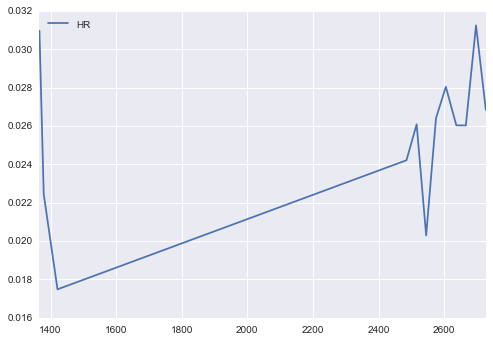

In [104]:
stats[stats["teamID"]=="LAA"][["HR"]].plot()

#### Problem 1(e) 

Using the `stats` DataFrame from Problem 1(c), adjust the singles per PA rates so that the average across teams for each year is 0. Do the same for the doubles, triples, HR, and BB rates. 

In [105]:
tf = stats['teamID']=="LAA"
yf = stats['yearID']==2012
stats[ yf & tf ][['S', '2B', '3B', 'HR', 'BB']]

,S,2B,3B,HR,BB
2697,0.173099,0.045614,0.003676,0.031245,0.075021


In [92]:
years = stats['yearID'].unique()

year_stats_collection = []

for year in years:
    year_selector = stats["yearID"] == year
    year_stats = stats[year_selector]
    year_stats[['S', '2B', '3B', 'HR', 'BB']] = stats[year_selector][['S', '2B', '3B', 'HR', 'BB']].apply(lambda df: (df - df.mean()) / df.std())
    year_stats_collection.append(year_stats)

stats_adj = pd.concat(year_stats_collection)

S     2.812565e-16
2B    3.650321e-15
3B    3.589721e-16
HR   -3.330669e-16
BB   -2.531308e-15
dtype: float64

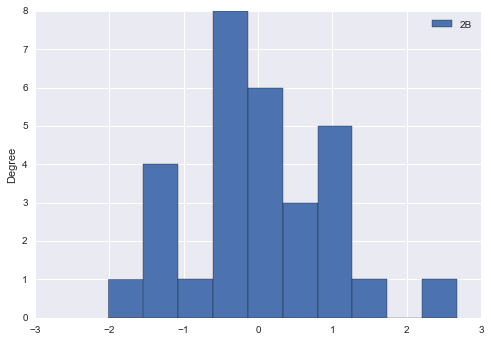

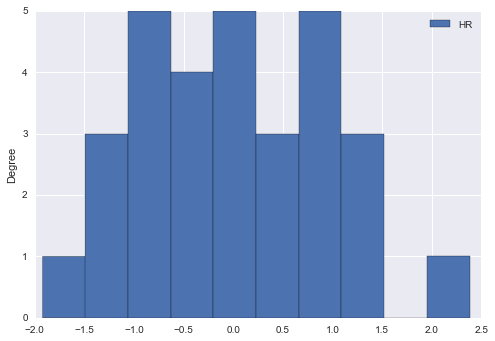

In [108]:
stats_adj[stats['yearID']==2012][['2B']].plot(kind="hist")
stats_adj[stats['yearID']==2012][['HR']].plot(kind="hist")
stats_adj.head()
tf = stats_adj['teamID']=="LAA"
yf = stats_adj['yearID']==2012
stats_adj[ yf ][['S', '2B', '3B', 'HR', 'BB']].mean()

#### Problem 1(f)

Build a simple linear regression model to predict the number of wins from the average adjusted singles, double, triples, HR, and BB rates. To decide which of these terms to include fit the model to data from 2002 and compute the average squared residuals from predictions to years past 2002. Use the fitted model to define a new sabermetric summary: offensive predicted wins (OPW). Hint: the new summary should be a linear combination of one to five of the five rates.


In [9]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

In [17]:
# labels=stats_adj[['S', '2B', '3B', 'HR', 'BB']].values
training_selector = stats_adj['yearID']>=2002
test_selector = stats_adj['yearID']<2002
labels=["S", "2B", "3B", "HR", "BB"]

training_data = stats_adj[training_selector]
test_data = stats_adj[test_selector]
X_train = training_data[labels].values
y_train = training_data[['W']].values
X_test = test_data[labels].values
y_test = test_data[['W']].values
# (stats_adj.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [11]:
labels=["S", "2B", "3B", "HR", "BB"]
data = stats_adj[labels].values
target = stats_adj[['W']].values
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=9)

In [12]:
(X_test.shape, y_test.shape)

((394, 5), (394, 1))

In [18]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
#  The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

# Plot outputs
# plt.scatter(X_test, y_test,  color='black')
# plt.plot(X_test, regr.predict(X_test), color='blue',linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

('Coefficients: \n', array([[ 3.31159476,  0.90636334,  0.26603641,  4.05150534,  3.85851507]]))
Residual sum of squares: 84.74
Variance score: 0.33


In [20]:
pd.DataFrame(regr.coef_)

,0,1,2,3,4
0,3.311595,0.906363,0.266036,4.051505,3.858515


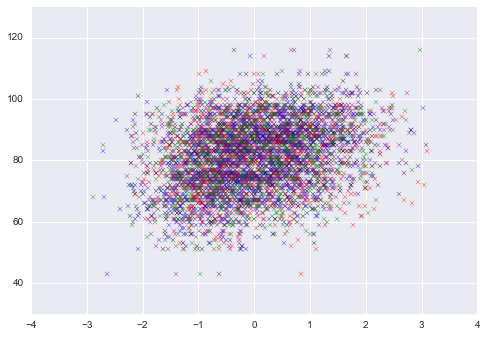

In [21]:
plt.scatter(stats_adj[["HR"]].values, stats_adj[["W"]].values,  color='black', marker="x")
plt.scatter(stats_adj[["3B"]].values, stats_adj[["W"]].values,  color='red', marker="x")
plt.scatter(stats_adj[["2B"]].values, stats_adj[["W"]].values,  color='blue', marker="x")
plt.scatter(stats_adj[["S"]].values, stats_adj[["W"]].values,  color='green', marker="x")
plt.scatter(stats_adj[["BB"]].values, stats_adj[["W"]].values,  color='purple', marker="x")

** Your answer here: **

#### Problem 1(g)

Now we will create a similar database for individual players. Consider only player/year combinations in which the player had at least 500 plate appearances. Consider only the years we considered for the calculations above (after 1947 and seasons with 162 games). For each player/year compute singles, doubles, triples, HR, BB per plate appearance rates. Create a new pandas DataFrame called `playerstats` that has the playerID, yearID and the rates of these stats.  Remove the average for each year as for these rates as done in Problem 1(e). 

In [32]:
appearances_selector = players["AB"] >= 500
year_selector = players["yearID"] > 1947
games_selector = players["G"] == 162


filtered_players = players[appearances_selector & year_selector & games_selector]

playerstats = filtered_players[["playerID", "yearID", "2B", "3B", "HR", "BB", "H"]].copy()
playerstats["S"] = playerstats["H"] - (playerstats["2B"] + playerstats["3B"] + playerstats["HR"])
playerstats.drop('H', axis=1, inplace=True)
playerstats.index
playerstats.sort("yearID", inplace=True)
playerstats.tail()

,playerID,yearID,2B,3B,HR,BB,S
14211,castrst01,2012,29,12,14,36,128
97506,pencehu01,2013,35,5,27,52,111
96755,butlebi03,2013,27,0,15,79,126
96968,fieldpr01,2013,36,0,25,75,113
97826,vottojo01,2013,30,3,24,135,120


In [58]:
years = playerstats['yearID'].unique()

for year in years:
    year_selector = playerstats["yearID"] == year
    year_stats = playerstats[year_selector]
    
    temp = playerstats[year_selector][['S', '2B', '3B', 'HR', 'BB']].copy()
    playerstats[year_selector][['S', '2B', '3B', 'HR', 'BB']] = (temp - temp.mean()) / temp.std()


In [59]:
playerstats_adj

,playerID,yearID,2B,3B,HR,BB,S
72882,richabo01,1961,NaN,-0.707107,-0.707107,-0.707107,0.707107
94941,woodja01,1961,NaN,0.707107,0.707107,0.707107,-0.707107
14401,cepedor01,1962,-0.467449,-1.214868,0.310038,-1.159496,0.780237
79873,siebeno01,1962,-0.557923,0.520658,-0.535519,1.570931,0.780237
73959,robinbr01,1962,-0.196027,1.561973,-0.704631,-0.972481,0.906761
76945,santoro01,1962,-1.010293,-0.173553,-1.211965,-0.112209,-1.307423
74049,robinfr02,1962,1.794400,-0.867763,0.648260,0.299225,-0.042175
55480,mayswi01,1962,0.437291,0.173553,1.493817,0.374031,-1.117636
76946,santoro01,1963,-0.293105,-0.800641,0.132453,-0.307339,-0.872872
92500,whitebi03,1963,-0.820695,-0.320256,0.927173,1.117598,1.091089


Show the head of the `playerstats` DataFrame. 

In [9]:
### Your code here ###

#### Problem 1(h)

Using the `playerstats` DataFrame created in Problem 1(g), create a new DataFrame called `playerLS` containing the player's lifetime stats. This DataFrame should contain the playerID, the year the player's career started, the year the player's career ended and the player's lifetime average for each of the quantities (singles, doubles, triples, HR, BB). For simplicity we will simply compute the avaerage of the rates by year (a more correct way is to go back to the totals). 

In [10]:
### Your code here ###

Show the head of the `playerLS` DataFrame. 

In [11]:
### Your code here ###

#### Problem 1(i)

Compute the OPW for each player based on the average rates in the `playerLS` DataFrame. You can interpret this summary statistic as the predicted wins for a team with 9 batters exactly like the player in question. Add this column to the playerLS DataFrame. Call this colum OPW.

In [12]:
### Your code here ###

#### Problem 1(j)

Add four columns to the `playerLS` DataFrame that contains the player's position (C, 1B, 2B, 3B, SS, LF, CF, RF, or OF), first name, last name and median salary. 

In [13]:
### Your code here ###

Show the head of the `playerLS` DataFrame. 

In [14]:
### Your code here ###

#### Problem 1(k)

Subset the `playerLS` DataFrame for players active in 2002 and 2003 and played at least three years. Plot and describe the relationship bewteen the median salary (in millions) and the predicted number of wins. 

In [15]:
### Your code here ###

#### Problem 1(l)
Pick one players from one of each of these 10 position C, 1B, 2B, 3B, SS, LF, CF, RF, DH, or OF keeping the total median salary of all 10 players below 20 million. Report their averaged predicted wins and total salary.

In [16]:
### Your code here ###

#### Problem 1(m)
What do these players outperform in? Singles, doubles, triples HR or BB?

In [17]:
### Your code here ###

** Your answer here: **

### 

### Use one of the classification methods to predict wheather a player will be an Allstar?

In [ ]:
### Your code here ###

## Discussion for Problem 1

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

# Problem 2:  $k$-Nearest Neighbors and Cross Validation 

What is the optimal $k$ for predicting species using $k$-nearest neighbor classification 
on the four features provided by the iris dataset.

In this problem you will get to know the famous iris data set, and use cross validation to select the optimal $k$ for a $k$-nearest neighbor classification. This problem set makes heavy use of the [sklearn](http://scikit-learn.org/stable/) library. In addition to Pandas, it is one of the most useful libraries for data scientists. 
For the Iris data set  sklearn provides an extra function to load it - since it is one of the very commonly used data sets.

In [5]:
#load the iris data set


#### Problem 2(a) 
Split the data into a train and a test set. Use a random selection of 33% of the samples as test data. Sklearn provides the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) function for this purpose. Print the dimensions of all the train and test data sets you have created. 

In [19]:
### Your code here ###

#### Problem 2(b) 

 Use ***ten fold cross validation*** to estimate the optimal value for $k$ for the iris data set. 

**Note**: For your convenience sklearn does not only include the [KNN classifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), but also a [grid search function](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV). The function is called grid search, because if you have to optimize more than one parameter, it is common practice to define a range of possible values for each parameter. An exhaustive search then runs over the complete grid defined by all the possible parameter combinations. This can get very computation heavy, but luckily our KNN classifier only requires tuning of a single parameter for this problem set. 

In [21]:
### Your code here ###

#### Problem 2(c)

Visualize the result by plotting the score results versus values for $k$. 

In [22]:
### Your code here ###

Verify that the grid search has indeed chosen the right parameter value for $k$.

In [23]:
### Your code here ###

#### Problem 2(d)

Test the performance of our tuned KNN classifier on the test set.

In [6]:
### Your code here ###

## Discussion for Problem 2

*Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.*

---

## Problem 3: Supervised Learning - Estimating Boston house pricing using Linear Regression and Regression Trees

##### Import the Boston House Pricing Dataset; it comes with the scikit or you can dowload it FROM UCI ML cars dataset. (https://archive.ics.uci.edu/ml/datasets/Automobile)

In [ ]:
### Your code here ###

#### Find the mostimportant features

In [ ]:
### Your code here ###

#### Using 10-fold cross validation separate the test and training data sets

In [ ]:
### Your code here ###

In [ ]:
Normalize the data

In [ ]:
### Your code here ###

### Start with a lineal model and evaluate how well it can predict the price variable

In [ ]:
### Your code here ###

### Try using Ridge regression and evaluate the result of the 10-fold cross-validation

In [ ]:
### Your code here ###

### Train the Regression Tree and evaluate using 10-fold cross validation; Specify the parapmeters used and how you changed them to increase the accuracy;  

In [ ]:
### Your code here ###

### Discussion for Problem 3  Write a brief discussion of your conclusions to the questions and tasks above in 100 words or less.Compare all three aproaches and discuss your findings in 100 words or less